Kütüphaneler

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline

Veri Okuma, Bilgi, Temizleme

In [2]:
uber_dataset_raw = pd.read_csv(r'C:\Users\fehime.gobeller\Desktop\Mindset-Project\Dataset\ncr_ride_bookings_2.csv')
uber_dataset= uber_dataset_raw.rename(columns={
    "Date": "date",
    "Time": "time",
    "Booking ID": "booking_id",
    "Booking Status": "booking_status",
    "Customer ID": "customer_id",
    "Vehicle Type": "vehicle_type",
    "Pickup Location": "pickup_location",
    "Drop Location": "drop_location",
    "Avg VTAT": "avg_vtat_min",   # (pickup'a varış süresi - dakika)
    "Avg CTAT": "avg_ctat_min",   # (yolculuk süresi - dakika)
    "Cancelled Rides by Customer": "cancelled_by_customer",
    "Reason for cancelling by Customer": "cancel_reason_customer",
    "Cancelled Rides by Driver": "cancelled_by_driver",
    "Driver Cancellation Reason": "cancel_reason_driver",
    "Incomplete Rides": "incomplete_ride",
    "Incomplete Rides Reason": "incomplete_reason",
    "Booking Value": "booking_value",
    "Ride Distance": "ride_distance_km",
    "Driver Ratings": "driver_rating",
    "Customer Rating": "customer_rating",
    "Payment Method": "payment_method"
})

In [3]:
uber_dataset.isnull().sum()

date                           0
time                           0
booking_id                     0
booking_status                 0
customer_id                    0
vehicle_type                   0
pickup_location                0
drop_location                  0
avg_vtat_min               10500
avg_ctat_min               48000
cancelled_by_customer     139500
cancel_reason_customer    139500
cancelled_by_driver       123000
cancel_reason_driver      123000
incomplete_ride           141000
incomplete_reason         141000
booking_value              48000
ride_distance_km           48000
driver_rating              57000
customer_rating            57000
payment_method             48000
norm_pickup_area               0
norm_vehicle_type              0
distance_km_clean              0
duration_min_est               0
area_surge                     0
time_surge                     0
airport_fee                    0
booking_value_original     48000
booking_value_adjusted     48000
dtype: int

In [4]:
# nooking Value null olan değerleri kaldır

uber_dataset_filtered = uber_dataset[uber_dataset['booking_status'].isin(["Completed", "Incomplete"])]

Sayısal Özellikler Arası Korelasyon

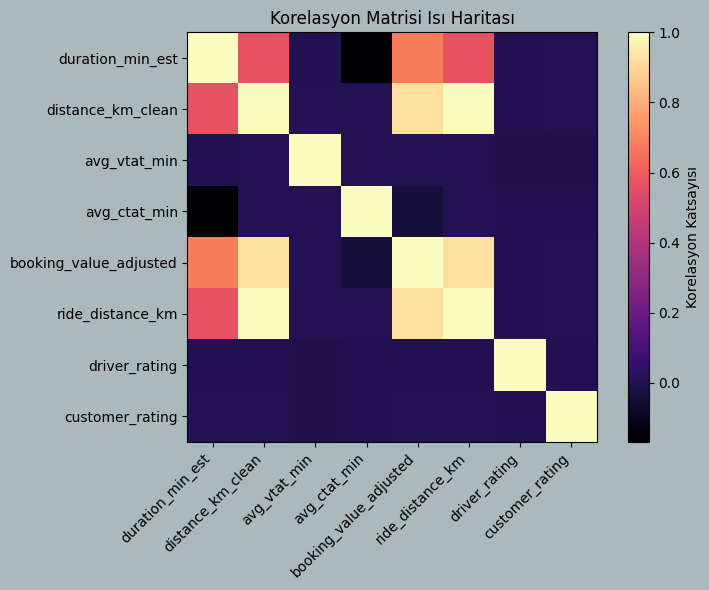

In [5]:
df = uber_dataset_filtered.copy()
# seçilen sütunlar
num_cols = ["duration_min_est", "distance_km_clean" , "avg_vtat_min", "avg_ctat_min",
            "booking_value_adjusted", "ride_distance_km", 
            "driver_rating", "customer_rating"]

# NaN değerleri düşür
df_corr = df[num_cols].dropna()


corr_matrix = df_corr.corr()

# heatmap
plt.figure(figsize=(8,6),facecolor="#ABB9BC")
plt.imshow(corr_matrix, cmap="magma", interpolation="nearest")
plt.colorbar(label="Korelasyon Katsayısı")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Korelasyon Matrisi Isı Haritası")
plt.tight_layout()
plt.show()


Kategorik + Sayısal Özellikler Arası Korelasyon

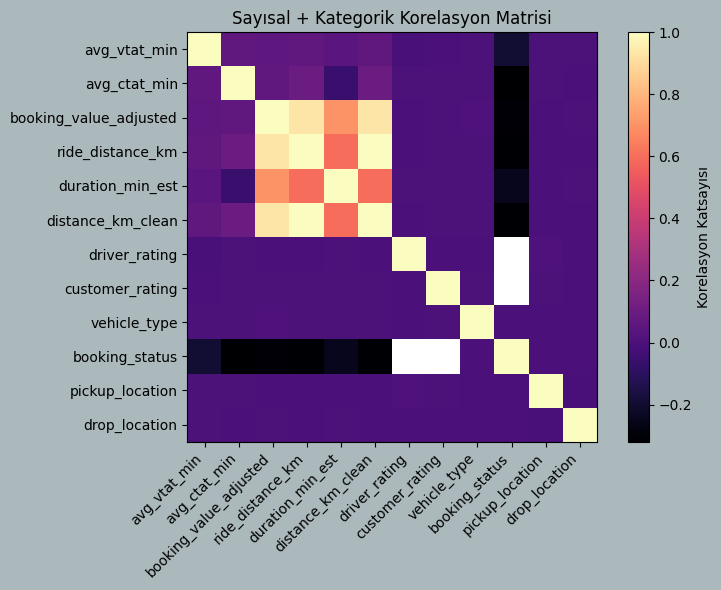

In [6]:


# Kategorik + Sayısal sütunlar
all_cols = ["avg_vtat_min", "avg_ctat_min", "booking_value_adjusted", "ride_distance_km", "duration_min_est", "distance_km_clean" 
            ,"driver_rating", "customer_rating", 
            "vehicle_type", "booking_status",
            "pickup_location", "drop_location"]

df_corr_all = df[all_cols].copy()

# Label Encoding -kategorik değişkenler için
le = LabelEncoder()
for col in df_corr_all.select_dtypes(include=['object']).columns:
    df_corr_all[col] = df_corr_all[col].astype(str)  # NaN sorununu çözmek için string
    df_corr_all[col] = le.fit_transform(df_corr_all[col])


corr_matrix_all = df_corr_all.corr()


# heatmap
plt.figure(figsize=(8,6),facecolor="#ABB9BC")
plt.imshow(corr_matrix_all, cmap="magma", interpolation="nearest")
plt.colorbar(label="Korelasyon Katsayısı")
plt.xticks(range(len(corr_matrix_all.columns)), corr_matrix_all.columns, rotation=45, ha="right")
plt.yticks(range(len(corr_matrix_all.columns)), corr_matrix_all.columns)
plt.title("Sayısal + Kategorik Korelasyon Matrisi")
plt.tight_layout()
plt.show()

PROBLEM TANIMI

Bir yolculuğun mesafesi,süresi üzerinden toplam ücretin (Booking Value) tahmin edilmesi

Hedef değişken: booking_value_adjusted
Özellikler: distance_km_clean,  avg_vtat_min, duration_min_est

Seçilen Modeller : Linear Regression, Random Forest, XGBoost

In [7]:
df = uber_dataset_filtered.copy()

features = ["distance_km_clean", "avg_vtat_min","duration_min_est"]
target = "booking_value_adjusted"

# Eksik/hatalı değerleri düşür
df = df[features + [target]].dropna()

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#modelleri tanımlama
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

# Model eğitimi ve değerlendirme
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        "Model": name,
        "MSE": round(mse, 2),
        "RMSE": round(rmse, 2),
        "MAE": round(mae, 2),
        "R2": round(r2, 3)
    })

# Sonuçları DataFrame olarak gösterme
results_uber_dataset = pd.DataFrame(results)
print("\n Model Performans Karşılaştırması ")
print(results_uber_dataset)
results_uber_dataset.to_csv(r"C:\Users\fehime.gobeller\Desktop\Mindset-Project\model_performance_comparison.csv", index=False)

# Sonuçları görselleştirme ve kaydetme
fig, ax = plt.subplots(figsize=(8, 2))  
ax.axis('off')  # eksenleri gizle
table = ax.table(cellText=results_uber_dataset.values,
                 colLabels=results_uber_dataset.columns,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.2)
output_path = r"C:\Users\fehime.gobeller\Desktop\Mindset-Project\model_results.png"
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.close()




 Model Performans Karşılaştırması 
               Model      MSE   RMSE    MAE     R2
0  Linear Regression  3121.96  55.87  36.70  0.900
1      Random Forest  3643.10  60.36  39.23  0.883
2            XGBoost  3192.89  56.51  36.83  0.898


Tahmin Edilen Sütunu Verisetine ekleme ve csv çıktısı

In [8]:

df_fit = uber_dataset_filtered[features + [target]].dropna().copy()

final_model = LinearRegression()
final_model.fit(df_fit[features], df_fit[target])

impute_values = df_fit[features].median().to_dict()


uber_dataset_with_pred = uber_dataset_filtered.copy()
predict_mask = uber_dataset_with_pred[features].notna().all(axis=1)

#Girdi tipleri
X_pred = uber_dataset_with_pred.loc[predict_mask, features].apply(
    pd.to_numeric, errors="coerce"
).fillna(value=impute_values)[features]

# Tahminleme
y_pred = final_model.predict(X_pred)

# Sütunu oluşturma
uber_dataset_with_pred["booking_value_predicted"] = np.nan
uber_dataset_with_pred.loc[predict_mask, "booking_value_predicted"] = y_pred

uber_dataset_with_pred.to_csv(r'C:\Users\fehime.gobeller\Desktop\Mindset-Project\Dataset\uber_dataset_with_predictions.csv', index=False)
print(uber_dataset_with_pred[[*features, target, "booking_value_predicted"]].head())

   distance_km_clean  avg_vtat_min  duration_min_est  booking_value_adjusted  \
1               5.73           4.9              14.0                  103.22   
2              13.58          13.4              25.8                  204.23   
3              34.02          13.1              28.5                  423.10   
4              48.21           5.3             113.6                  508.03   
5               4.85           5.1              18.1                  100.43   

   booking_value_predicted  
1                97.752975  
2               193.190291  
3               399.785025  
4               671.562893  
5                95.330890  
